In [1]:
from dask.distributed import Client, LocalCluster
import dask.array as da
import dask
import dask.dataframe as dd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA as IPCA
from sklearn.cluster import KMeans

import numpy as np
import xarray as xr
import rioxarray
from numba import jit

import matplotlib.pyplot as plt

import os
import random
from time import time

# launch a scheduler and workers locally
cluster = LocalCluster()

# connect to cluster
client = Client(cluster)

client

distributed.diskutils - INFO - Found stale lock file and directory '/home/michael/Work/NEON/dask-worker-space/worker-ht29pcm0', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/michael/Work/NEON/dask-worker-space/worker-jig6tmte', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/michael/Work/NEON/dask-worker-space/worker-gmo246is', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/michael/Work/NEON/dask-worker-space/worker-eer_zqor', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/michael/Work/NEON/dask-worker-space/worker-nnirl7gz', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/michael/Work/NEON/dask-worker-space/worker-d8ye68eq', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 24,Total memory: 31.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35635,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 31.21 GiB
Comm: tcp://127.0.0.1:41125,Total threads: 4
Dashboard: http://127.0.0.1:43055/status,Memory: 5.20 GiB
Nanny: tcp://127.0.0.1:38799,


## Training the scaler

First we will use pixels sampled from the full data set  to create a train and determine parameters for the StandardScaler.

In [2]:
@jit
def resh(arr, dim):
    '''reshapes from 3d (x,y,wl) to 2d (x*y,wl)'''
    arr = arr.reshape(-1, dim)
    return arr


def train_scaler_multi_nc(files, variable, size=0.025):
    '''
    Returns a sklearn StandardScaler, and PCA instnace trained on a random sample drawn from 
    variable found within netcdf4s in a list of files, as well as the scaled data.  Curently assumes
    variable is a 3D array.
    
    arg:
        files    - list of full paths to netcdf4 files to be used.
        variable - variable from within dataset of interest. 
        size     - fraction of data to be used.
    '''
    
    # open all the files in a lazy way
    data = xr.open_mfdataset(files)

    # generate indices to randomply sample pixels
    xs = random.sample(range(data.x.shape[0]), int(data.x.shape[0] * size))
    ys = random.sample(range(data.y.shape[0]), int(data.y.shape[0] * size))
    xs.sort()

    # get wl dimension size
    wl = data[variable].shape[2]

    # extract the sample and switch to numpy
    refl = np.array(data.isel(x=xs, y=ys)[variable].data)

    # reshape
    flat_refl = resh(refl, wl)

    # drop nulls
    flat_refl = flat_refl[
        (~da.any(flat_refl == -9999, axis=1)) &
        (~da.any(da.isnan(flat_refl), axis=1))]

    # scale the data
    scaler = StandardScaler().fit(flat_refl)
    scaled_refl = scaler.transform(flat_refl)

    # instantiate the PCA thingy
    pca = PCA()

    # fit the pca model
    pca.fit(scaled_refl)

    
    return(scaler, pca, scaled_refl)


def plot_pca_var(pca):
    '''plots explained variance by PCA component'''
    
    # make fig
    plt.figure(figsize=(10,4));

    # plot
    plt.plot(range(1, 359),
             pca.explained_variance_ratio_.cumsum(),
             marker='o',
             linestyle='--');
    
    # details
    plt.title('Explained Variance by Number of Components');
    plt.xlabel('Components');
    plt.ylabel('Cumulative explained Var');
    plt.xlim(0, 20);
    plt.show()


def kmeans_wcss(n_components, scaled_refl, max_n_clusters=20):
    '''
    Returns a list of wcss values for different n_clusters values
    after performing PCA using n_components.
    args:
        n_components   - number of components to be kept in PCA.
        scaled_refl    - scaled values on which to perform PCA and
                         clustering.
        max_n_clusters - max number of clusters to try default 20.
    '''
    # use two components for pca
    pca = PCA(n_components=n_components)

    # fit
    pca.fit(scaled_refl)

    # get component scores
    scores_pca = pca.transform(scaled_refl)

    # empty list for witih cluster sum of squares
    wcss = []

    # now try out some differnt cluster numbers
    print(f'Out of {max_n_clusters} trials working on:')

    for n in range(1, max_n_clusters + 1):
        
        print(f'\b\b{n}', end="")
        
        kmeans =  KMeans(n_clusters=n, init='k-means++', random_state=42)
        kmeans.fit(scores_pca)
        wcss.append(kmeans.inertia_)

    print('\ndone!')
    
    return wcss


def plot_wcss(wcss):
    '''plots wcss vs n_clusters'''
    
    # fig
    plt.figure(figsize=(10,4));

    # plot
    plt.plot(range(1, len(wcss) + 1),
             wcss,
             marker='o',
             linestyle='--');

    # details
    plt.title('Kmeans with PCA WCSS');
    plt.xlabel('WCSS');
    plt.ylabel('Number of Clusters');



For each site the reflectance files were converted from hdf5 format to netcdf4 using **--------**.  The netcdf files were then read to an Xarray (**version , citation**) as a multi-file dataset.  Pixels were then randomly sampled from the dataset. The randomly assembled smaller dataset was then scaled using the standard scaler from Sklearn (**version , citation**) and pca was fit to the data.  Cumulative explained variance vs number of PCA components was plotted and used to select the number of components to use for clustering.  The number of clusters to use  ($n_{clusters}$) was chosen to encompass at least 80\% of explained variance typically resulting in **2 - 3 components with some using more blah blah**.  The fit PCA model was then used to transform the sample dataset using $n_{clusters}$ components and K-means clustering was then carried out on the resulting components for number of clusters (*n_clusters*) ranging from  2 - 20 clusters.  Within-cluster sum of squares (WCSS) was then calculated for each $n_{clusters}$. WCSS was plotted against $n_{clusters}$. The plot was visually inspected for an the inflection point in order to select the optimal number value of $n_{clusters}$.    

In [3]:
# path and sitename
site = 'TALL'
path = f'/media/data/NEON/{site}'
data = f'{path}/hyperspectral/DP3.30006.001/2021/FullSite/D08/2021_TALL_6/L3/Spectrometer/Reflectance'

# chunksize in bytes
chunksize = 4_000_000_000

# find the filenames
files = [os.path.join(data, f)
         for f
         in os.listdir(data)
         if '.nc' in f
         and site in f]

# train the scaler on a sample
scaler, pca, scaled_refl = train_scaler_multi_nc(files, 'reflectance')

/home/michael/miniconda3/envs/geo3/lib/python3.10/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  value = value[(slice(None),) * axis + (subkey,)]


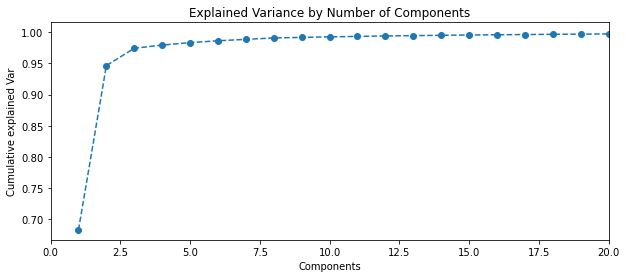

In [4]:
plot_pca_var(pca)

From the figure above we can see that two components explain well over 8-% of the variance. Thus we will use two components. Now from the sample we need to determine the number of clusters to use.

Out of 10 trials working on:
10
done!


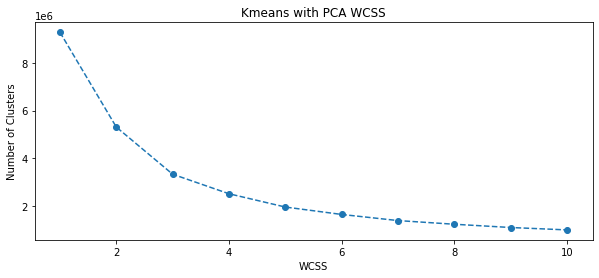

In [5]:
# 2 components as discussed above
n_components = 2

# get wcss for different n_clusters
wcss = kmeans_wcss(n_components, scaled_refl, max_n_clusters=10)

# plot
plot_wcss(wcss)

Using the "elbow rule" we will choose 3 clusters.

In [6]:
# 3 clusters as discussed above
n_clusters = 3

## PCA and clusterin on full data

Due to the size of the dataset we will need to use incremental PCA (IPCA) chunk by chunk on the dataset.

In [7]:
# instantiate IPCA
ipca = IPCA(n_components=n_components)

# make a generator to extract reflectances file by file
refl_gen = (xr.open_dataset(f) for f in files)

# for each file
print('fitting IPCA')
print(f'Out of {len(files)} on:')
i = 1

for xarr in refl_gen:
    # print progress
    print(f'\b\b{i}', end="")
    i = i + 1
    
    # get wl dimension size
    wl = xarr['reflectance'].shape[2]
    
    # extract the sample as np array
    refl = np.array(xarr['reflectance'].data)  
    
    # reshape
    flat_refl = resh(refl, wl)

    # drop nulls
    flat_refl = flat_refl[
        (~da.any(flat_refl == -9999, axis=1)) &
        (~da.any(da.isnan(flat_refl), axis=1))]
    
    # scale with previously fit scaler
    scaled = scaler.transform(flat_refl)
    
    # partially fit the ipca
    ipca.partial_fit(scaled)

fitting IPCA
Out of 49 on:
49

First tried training the using the previously trained scaler.  The resulting tiles  strongly visible boundaries due to differences in clustering across them.  Now try training scaler for each tile.  Stiil not working. They clustering seems to be working the same way across tiles, except the labels are inconsistent (and there are some weird tiles that are just solid and divided by flightline)

For each site 

In [8]:
# reinitialize generator, this time with basename
refl_gen = ((xr.open_dataset(f), os.path.basename(f).split('.')[0]) for f in files)

# ensure directory for tiffs exists and make path
tiff_house = os.path.join(path, 'pca')
os.makedirs(tiff_house, exist_ok=True)

# for each file
print('\n\ngetting IPCA scores and clustering')
print(f'Out of {len(files)} on:')
i = 1
with_nans = 0

for xarr, base in refl_gen:
    # get null indices
    nan_idx = np.argwhere(
        (np.any(flat_refl == -9999, axis=1)) |
        (np.any(np.isnan(flat_refl), axis=1))
    )

    # also get valid indices (probably a way to avoid this)
    val_idx = np.argwhere(
        (~np.any(flat_refl == -9999, axis=1)) |
        (~np.any(np.isnan(flat_refl), axis=1))
    )

    # print progress and null count
    print(f'{i} ({nan_idx.shape[0]} nulls)', end="\r")
    i = i + 1
    
    # get wl dimension size
    wl = xarr['reflectance'].shape[2]
    
    # extract the sample as np array
    refl = np.array(xarr['reflectance'].data)  
    
    # reshape
    flat_refl = resh(refl, wl)

    # drop nulls
    if np.any(nan_idx):
        flat_refl = flat_refl[val_idx]
    print(flat_refl.shape)

    # scale 
    #scaler = StandardScaler().fit(flat_refl)
    scaled = scaler.transform(flat_refl)

    # get component scores
    scores_pca = ipca.transform(scaled)

    # put the no data values back
    if np.any(nan_idx):
        new_shape = (flat_refl.shape[0], scores_pca[1])
        nines = np.full(new_shape, -999)
        nines[val_idx] = scores_pca

        with_nans += 1

   # add the components to the xarray
    xarr['pca'] = xr.DataArray(scores_pca.reshape(1000, 1000, n_components), dims=['x', 'y', 'component'])

    # make fname
    tiff = os.path.join(tiff_house, f'{base}_pca.tiff')
    
    # write the labels to geotiff
    xarr.pca.transpose('component', 'y', 'x').rio.to_raster(tiff)

print(f'{with_nans} tiles had null values.')



getting IPCA scores and clustering
Out of 49 on:
(1000000, 358)
(1000000, 358)
(1000000, 358)
(1000000, 358)
(1000000, 1, 358)


ValueError: Found array with dim 3. StandardScaler expected <= 2.

tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/home/michael/miniconda3/envs/geo3/lib/python3.10/site-packages/tornado/websocket.py", line 954, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/home/michael/miniconda3/envs/geo3/lib/python3.10/site-packages/tornado/web.py", line 3173, in wrapper
    return method(self, *args, **kwargs)
  File "/home/michael/miniconda3/envs/geo3/lib/python3.10/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.


In [ ]:
 # cluster
    kmeans =  KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans.fit(scores_pca)

    # get labels
    labels = kmeans.labels_

    # put the no data values back
    if np.any(nan_idx):
        labels[nan_idx] = -999
          
    # add the labels to the xarray
    xarr['cluster'] = xr.DataArray(labels.reshape(1000, 1000), dims=['x', 'y'])

    # make fname
    tiff = os.path.join(tiff_house, f'{base}_kmeans.tiff')
    
    # write the labels to geotiff
    xarr.cluster.transpose('y', 'x').rio.to_raster(tiff)

In [10]:
print('done')

done


In [39]:
a = np.full((4, 2), 10)
a.shape

(4, 2)

In [38]:
b = np.full((10, 2), -999)
b

array([[-999, -999],
       [-999, -999],
       [-999, -999],
       [-999, -999],
       [-999, -999],
       [-999, -999],
       [-999, -999],
       [-999, -999],
       [-999, -999],
       [-999, -999]])

In [40]:
idx = np.array([2, 4, 6, 8])
idx

array([2, 4, 6, 8])

In [41]:
b[idx] = a

In [42]:
b

array([[-999, -999],
       [-999, -999],
       [  10,   10],
       [-999, -999],
       [  10,   10],
       [-999, -999],
       [  10,   10],
       [-999, -999],
       [  10,   10],
       [-999, -999]])